# **Setup for Natural Language Processing Tasks**

In [2]:
import nltk
nltk.download('stopwords')

!pip install pyspellchecker

import nltk
nltk.download('wordnet')

!pip install tweet-preprocessor


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 19.4 MB/s eta 0:00:00


[nltk_data] Downloading package wordnet to /root/nltk_data...


# **Imports and Setup for Data Processing and Machine Learning**

In [ ]:
import pandas as pd
import numpy as np
import re
from nltk.stem import SnowballStemmer, PorterStemmer
from nltk.corpus import stopwords
from collections import Counter
from spellchecker import SpellChecker
import csv
import string
import matplotlib.pyplot as plt
import seaborn as sns
import preprocessor as p
import tensorflow as tf
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Reading and Displaying Data from CSV File**

In [27]:
nRows = None
df_all = pd.read_csv('/content/drive/MyDrive/data/training.1600000.processed.noemoticon.csv', delimiter=',', nrows=nRows, encoding='latin1')
df_all.dataframeName = 'training.1600000.processed.noemoticon.csv'
print("Number of rows in the dataset:", len(df_all))
df_all.tail()

Number of rows in the dataset: 1599999


,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599998,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


# **Function to Plot Correlation Matrix**

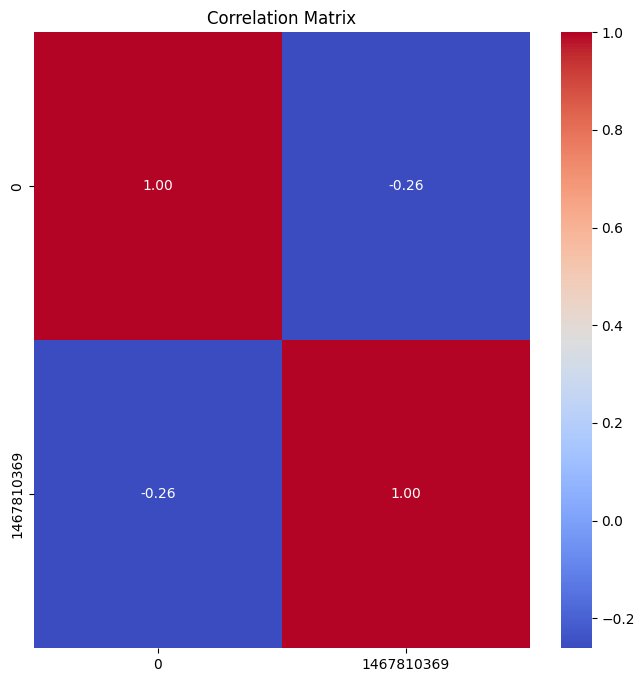

In [ ]:
def plot_correlation_matrix(df, size):
    # Select only numeric columns
    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    plt.figure(figsize=(size, size))
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix')
    plt.show()

plot_correlation_matrix(df_all, 8)

# **Function to Plot Scatter and Density Matrix**

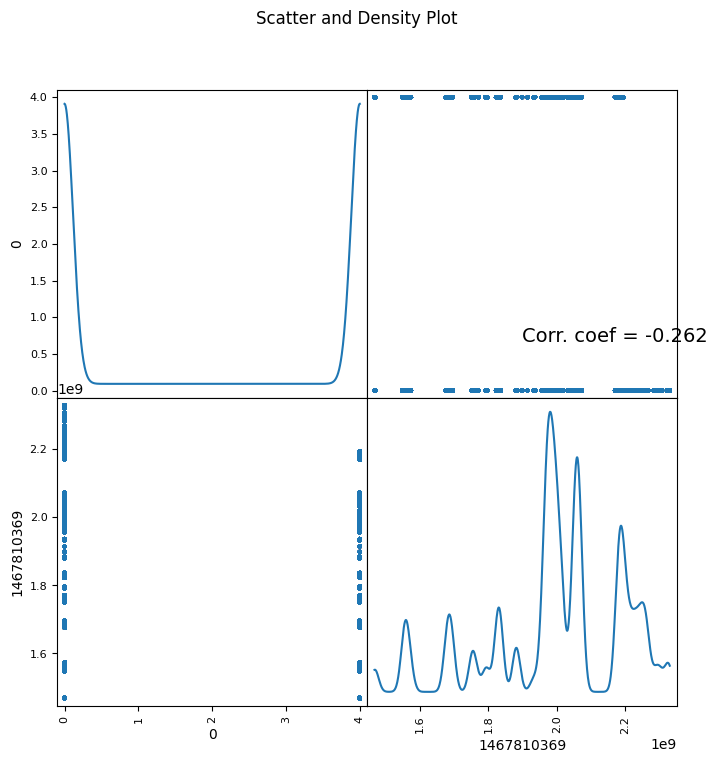

In [ ]:
def plotScatterDensity(df, plotSize):
    numeric_cols = df.select_dtypes(include=[np.number]).dropna(axis=1, how='all')
    numeric_cols = numeric_cols.loc[:, numeric_cols.nunique() > 1].iloc[:, :5]
    scatter_matrix = pd.plotting.scatter_matrix(numeric_cols, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = numeric_cols.corr().values
    for i, j in zip(*np.triu_indices_from(scatter_matrix, k=1)):
        scatter_matrix[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=14)

    plt.suptitle('Scatter and Density Plot')
    plt.show()

plotScatterDensity(df_all, 8)


# **Tweet Preprocessing Function**

In [28]:
# Initialize Porter Stemmer
stemmer = PorterStemmer()

# Function to preprocess a single tweet
def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove emails
    tweet = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', tweet)

    # Remove HTML tags, URLs, and mentions
    tweet = p.clean(tweet)

    # Remove non-word characters, punctuation, and specific two-letter words
    tweet = re.sub(r'[^\w\s]|(http\S+)|(www.\S+)|(@\S+)|(\b\w{1,2}\b)', '', tweet)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    stop_words.update(['new', 'way'])
    tweet = ' '.join(word for word in tweet.split() if word not in stop_words)

    # Radicalization of words using stemming
    tweet = ' '.join(map(lambda word: stemmer.stem(word), tweet.split()))

    # Delete numbers
    tweet = re.sub(r'\b\d+\b', '', tweet)

    # Remove non-printable characters
    tweet = ''.join(char for char in tweet if char in string.printable)

    return tweet

**Note :**
After testing out the models with both the full dataset and smaller samples, we found consistent results. We then tried them with subsets of 700,000 and 200,000 lines, and the performance remained consistent. When comparing the 200,000-line subset with the 100,000-line one, we didn't notice any performance change. So, we settled on the 100,000-line set, splitting it evenly into 50,000 positive and 50,000 negative instances. Interestingly, we realized that changing the dataset size didn't affect performance much, but the vocabulary size did. Experimenting with different vocabulary sizes (K values), we found that K=1078 worked best. Trying higher or lower values gave worse accuracy, but with K=1078, we got good results.

In [ ]:
# Define the number of rows to read for each category
num_rows_per_category = 50000

# Read the first 50,000 rows (negative tweets)
df = pd.read_csv('/content/drive/MyDrive/data/training.1600000.processed.noemoticon.csv',
                 delimiter=',', nrows=num_rows_per_category, encoding='latin1', header=None)

# Skip the next 1500,000 rows and read the next 50,000 rows (positive tweets)
positive_df = pd.read_csv('/content/drive/MyDrive/data/training.1600000.processed.noemoticon.csv',
                          delimiter=',', skiprows=num_rows_per_category + 1500000,
                          nrows=num_rows_per_category, encoding='latin1', header=None)

# Concatenate the positive tweets to the existing DataFrame
df = pd.concat([df, positive_df], ignore_index=True)

print(len(df))

100000


In [ ]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.tail()

,0,1,2,3,4,5
99995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
99996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
99997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
99998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
99999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


# **Constructing Vocabulary from Tweets**


**Note :**
The approach here was to construct the vocabulary and extract relevant characteristics using the entire dataset, and not from the 100k subset.

In [29]:
def construct_vocabulary(tweet_list, min_occurrences):
    # Count occurrences of each word in the corpus
    word_counts = Counter(word for tweet in tweet_list for word in tweet.split())

    # Filter words based on minimum occurrences
    vocabulary = [word for word, count in word_counts.items() if count >= min_occurrences]

    # Save vocabulary to a file
    with open('vocab.txt', 'w', encoding='utf-8') as file:
        file.write('\n'.join(vocabulary))

    # Create a dictionary to map words to their indices
    word_to_index = {word: index for index, word in enumerate(vocabulary)}

    return word_to_index

# Preprocess all tweets
preprocessed_tweets = [preprocess_tweet(tweet) for tweet in df_all[df_all.columns[5]]]

print(len(preprocessed_tweets))

1599999


In [30]:
# Construct vocabulary and map words to their indices
vocab_word_to_index = construct_vocabulary(preprocessed_tweets, min_occurrences=1078)

for word, index in vocab_word_to_index.items():
    print(f'{word}: {index}')

upset: 0
updat: 1
facebook: 2
text: 3
might: 4
cri: 5
result: 6
school: 7
today: 8
also: 9
blah: 10
mani: 11
time: 12
ball: 13
manag: 14
save: 15
rest: 16
whole: 17
bodi: 18
feel: 19
like: 20
fire: 21
mad: 22
see: 23
need: 24
hug: 25
hey: 26
long: 27
ye: 28
rain: 29
bit: 30
lol: 31
fine: 32
thank: 33
nope: 34
spring: 35
break: 36
citi: 37
ear: 38
bear: 39
watch: 40
thought: 41
count: 42
idk: 43
either: 44
never: 45
talk: 46
anymor: 47
would: 48
first: 49
realli: 50
though: 51
wish: 52
got: 53
miss: 54
death: 55
hurt: 56
film: 57
cut: 58
file: 59
ahh: 60
ive: 61
alway: 62
want: 63
love: 64
dear: 65
drink: 66
day: 67
get: 68
much: 69
done: 70
one: 71
friend: 72
call: 73
ask: 74
meet: 75
sigh: 76
bake: 77
cake: 78
ate: 79
week: 80
go: 81
hope: 82
class: 83
tomorrow: 84
hate: 85
wake: 86
peopl: 87
sleep: 88
sad: 89
almost: 90
except: 91
track: 92
depress: 93
everi: 94
account: 95
make: 96
ride: 97
may: 98
realiz: 99
morn: 100
work: 101
afternoon: 102
eye: 103
night: 104
sick: 105
spent: 10

# **Converting Tweets into Binary Feature Vectors**

In [ ]:
# Preprocess the 100,000 tweets to exctrat from them the binary features
preprocessed_tweets = [preprocess_tweet(tweet) for tweet in df[df.columns[5]]]

print(len(preprocessed_tweets))

100000


In [7]:
# Function to convert each tweet into a binary feature vector
def binary_feature_extraction(tweet_list, vocab_word_to_index):
    num_features = len(vocab_word_to_index)
    num_tweets = len(tweet_list)
    feature_matrix = np.zeros((num_tweets, num_features), dtype=int)

    for i, tweet in enumerate(tweet_list):
        words = tweet.split()
        preprocessed_tweet = []
        for word in words:
            if word in vocab_word_to_index:
                feature_index = vocab_word_to_index[word]
                feature_matrix[i, feature_index] = 1

    return feature_matrix

# Convert tweets to binary feature vectors
binary_feature_vectors = binary_feature_extraction(preprocessed_tweets, vocab_word_to_index)

# Convert binary feature vectors to DataFrame
binary_feature_df = pd.DataFrame(binary_feature_vectors, columns=vocab_word_to_index.keys())

binary_feature_df.tail()

,upset,updat,facebook,text,might,cri,result,school,today,also,...,wii,toe,success,august,laker,luv,million,mcfli,thx,adam
99995,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
99996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
99999,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Machine learning Models

# **1. Logistic Regression**

In [ ]:

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Initialize Logistic Regression with 'saga' solver
logistic_regression = LogisticRegression(penalty='l2', solver='saga', C=0.1, max_iter=1000, random_state=42)

# Train the model on the training data
logistic_regression.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = logistic_regression.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the trained model
dump(logistic_regression, 'logistic_regression_model.h5')


Accuracy: 0.7510
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74     10035
           4       0.73      0.79      0.76      9965

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000

Confusion Matrix:
[[7161 2874]
 [2107 7858]]


['logistic_regression_model.h5']

# **1.1. Affichage Logistic Regression**

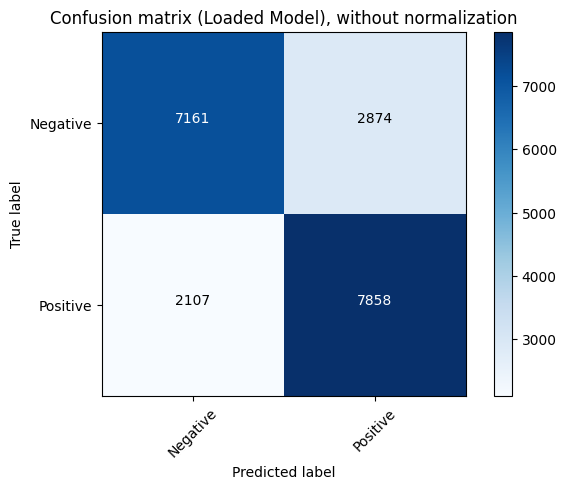

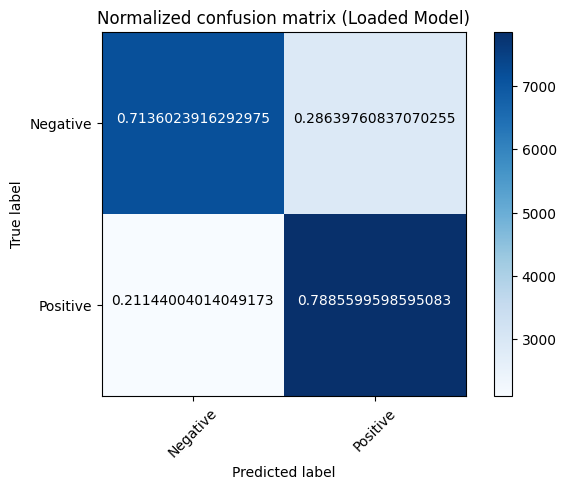

In [ ]:
from joblib import load
import itertools

# Plot confusion matrix function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


loaded_model = load('logistic_regression_model.h5')

# use the loaded_model to make predictions
y_pred_loaded = loaded_model.predict(X_test)

# Compute confusion matrix for the loaded model
cnf_matrix_loaded = confusion_matrix(y_test, y_pred_loaded)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'],
                      title='Confusion matrix (Loaded Model), without normalization')

# Plot normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'], normalize=True,
                      title='Normalized confusion matrix (Loaded Model)')

plt.show()


# **2. KNN Model**

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Initialize KNN classifier
knn = KNeighborsClassifier(n_neighbors=7)

# Train the model on the training data
knn.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = knn.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the trained model
dump(knn, 'knn_model.h5')


Accuracy: 0.6774
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.60      0.65     10035
           4       0.65      0.75      0.70      9965

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000

Confusion Matrix:
[[6069 3966]
 [2485 7480]]


['knn_model.h5']

# **2.1 Affichage KNN**

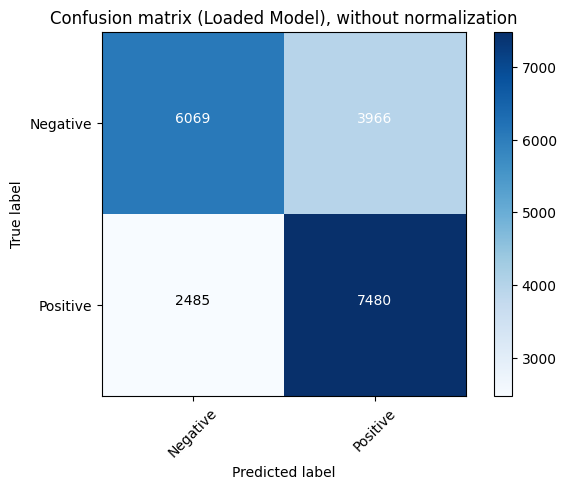

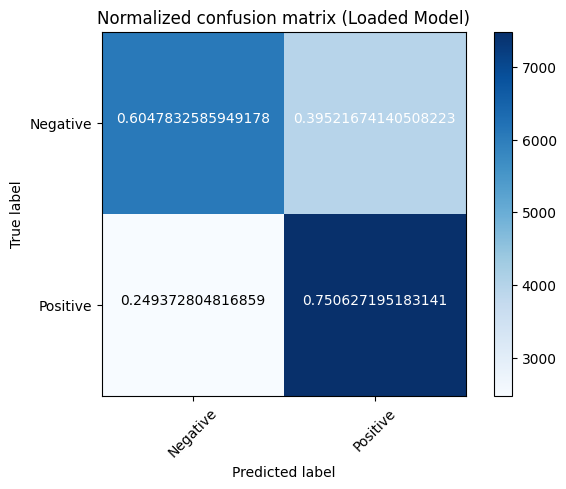

In [8]:
from joblib import load
import itertools

# Plot confusion matrix function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Load the saved model
loaded_model = load('knn_model.h5')

# use the loaded_model to make predictions
y_pred_loaded = loaded_model.predict(X_test)

# Compute confusion matrix for the loaded model
cnf_matrix_loaded = confusion_matrix(y_test, y_pred_loaded)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'],
                      title='Confusion matrix (Loaded Model), without normalization')

# Plot normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'], normalize=True,
                      title='Normalized confusion matrix (Loaded Model)')

plt.show()


# **3. DecisionTreeClassifier**

In [25]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Initialize Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the model on the training data
decision_tree.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = decision_tree.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the trained model as .h5 file
dump(decision_tree, 'decision_tree_model.h5')


Accuracy: 0.6791
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.69      0.68     10035
           4       0.68      0.67      0.67      9965

    accuracy                           0.68     20000
   macro avg       0.68      0.68      0.68     20000
weighted avg       0.68      0.68      0.68     20000

Confusion Matrix:
[[6920 3115]
 [3303 6662]]


['decision_tree_model.h5']

# **3.1 Affichage DecisionTreeClassifier**

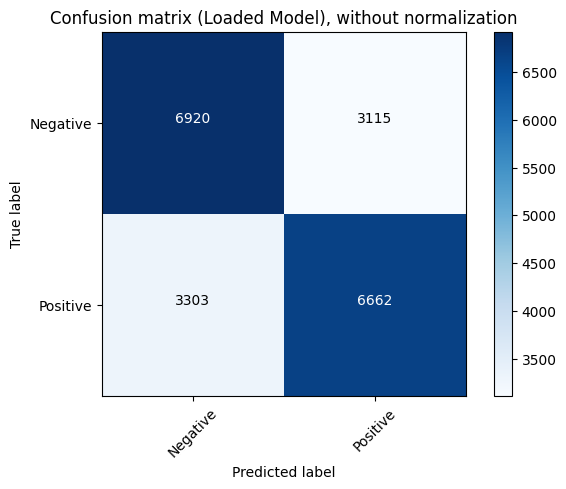

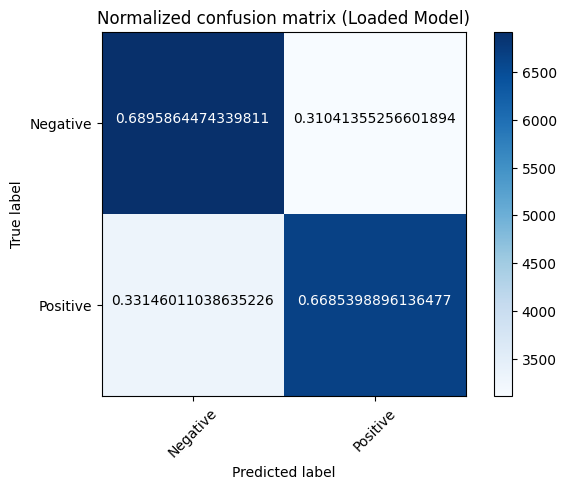

In [26]:
from joblib import load
import itertools

# Plot confusion matrix function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


loaded_model = load('decision_tree_model.h5')

# use the loaded_model to make predictions
y_pred_loaded = loaded_model.predict(X_test)

# Compute confusion matrix for the loaded model
cnf_matrix_loaded = confusion_matrix(y_test, y_pred_loaded)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'],
                      title='Confusion matrix (Loaded Model), without normalization')

# Plot normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'], normalize=True,
                      title='Normalized confusion matrix (Loaded Model)')

plt.show()


# **4. Linear Regression**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from joblib import dump

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Initialize Stochastic Gradient Descent Regressor
sgd_reg = SGDRegressor(
    max_iter=10000,  # Increase max_iter
    tol=1e-3,
    penalty='l2',  # L2 regularization (Ridge)
    alpha=0.01,  # Adjust regularization strength
    learning_rate='adaptive',  # Use adaptive learning rate
    eta0=0.01,  # Initial learning rate
    random_state=42
)


# Train the model on the training data
sgd_reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = sgd_reg.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Save the trained model
dump(sgd_reg, 'sgd_regression_model.h5')


Mean Squared Error (MSE): 3.1564
Root Mean Squared Error (RMSE): 1.7766
R-squared (R2): 0.2109


['sgd_regression_model.h5']

# **5. Random Forest Classifier**

In [29]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from joblib import dump

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

# Calculate the accuracy score for Random Forest Classifier
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {accuracy_rf:.4f}")

# Print the classification report for Random Forest Classifier
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Calculate confusion matrix for Random Forest Classifier
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (Random Forest):")
print(conf_matrix_rf)

# Save the trained random forest classifier model
dump(rf_classifier, 'random_forest_classifier_model.h5')


Accuracy (Random Forest): 0.7275
Classification Report (Random Forest):
              precision    recall  f1-score   support

           0       0.73      0.72      0.73     10035
           4       0.72      0.73      0.73      9965

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000

Confusion Matrix (Random Forest):
[[7245 2790]
 [2661 7304]]


['random_forest_classifier_model.h5']

# **6.1. Affichage Random Forest**

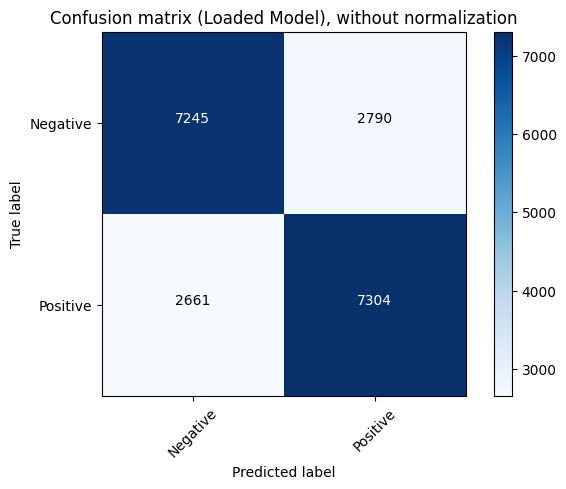

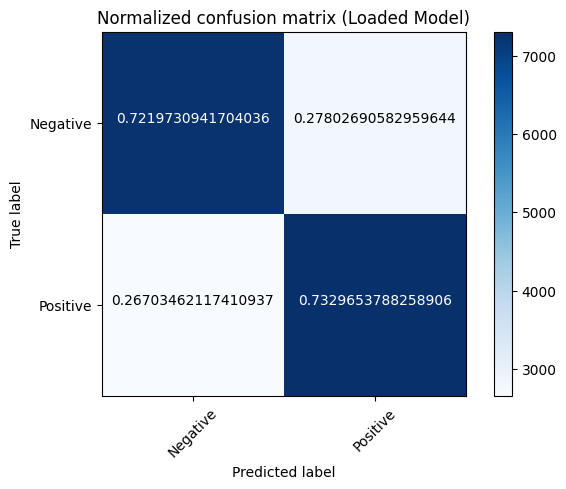

In [30]:
from joblib import load
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Load the saved model
loaded_model = load('random_forest_classifier_model.h5')

# Now, you can use the loaded_model to make predictions
y_pred_loaded = loaded_model.predict(X_test)

# Compute confusion matrix for the loaded model
cnf_matrix_loaded = confusion_matrix(y_test, y_pred_loaded)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'],
                      title='Confusion matrix (Loaded Model), without normalization')

# Plot normalized confusion matrix 
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'], normalize=True,
                      title='Normalized confusion matrix (Loaded Model)')

plt.show()


# **6. Naive Bayes**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Initialize Naive Bayes Classifier
naive_bayes = GaussianNB()

# Train the model on the training data
naive_bayes.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = naive_bayes.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the trained model
dump(naive_bayes, 'naive_bayes_model.h5')


Accuracy: 0.6915
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.60      0.66     10035
           4       0.66      0.78      0.72      9965

    accuracy                           0.69     20000
   macro avg       0.70      0.69      0.69     20000
weighted avg       0.70      0.69      0.69     20000

Confusion Matrix:
[[6023 4012]
 [2158 7807]]


['naive_bayes_model.h5']

# **6.1. Affichage Naive Bayes**

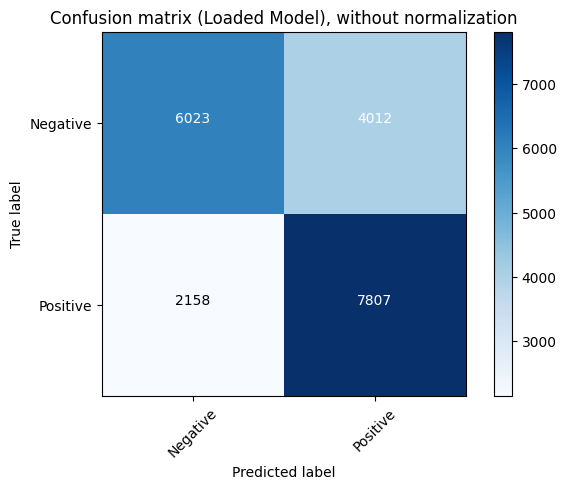

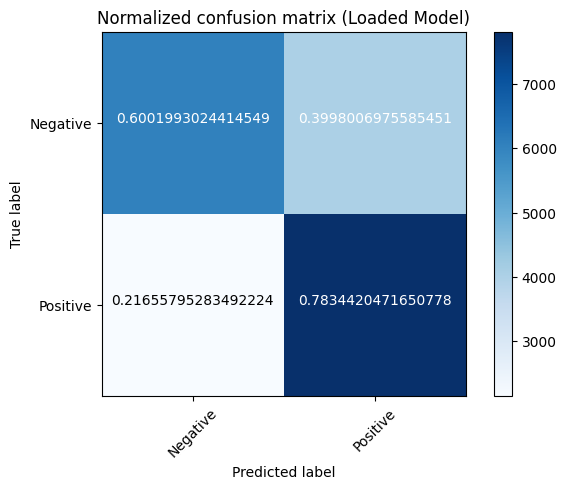

In [ ]:
from joblib import load
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Plot confusion matrix function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Load the saved model
loaded_model = load('naive_bayes_model.h5')

# Now, you can use the loaded_model to make predictions
y_pred_loaded = loaded_model.predict(X_test)

# Compute confusion matrix for the loaded model
cnf_matrix_loaded = confusion_matrix(y_test, y_pred_loaded)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'],
                      title='Confusion matrix (Loaded Model), without normalization')

# Plot normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'], normalize=True,
                      title='Normalized confusion matrix (Loaded Model)')

plt.show()


# **7. SVM**

In [27]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from joblib import dump

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Initialize SVM classifier with linear kernel
svm_classifier = SVC(kernel='rbf', C=0.1, random_state=42, max_iter=1000, tol=1e-3, verbose=True)

# Train the model on the training data
svm_classifier.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = svm_classifier.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save the trained model
dump(svm_classifier, 'svm_model.h5')


[LibSVM]

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.5351
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.66      0.59     10035
           4       0.54      0.41      0.47      9965

    accuracy                           0.54     20000
   macro avg       0.54      0.53      0.53     20000
weighted avg       0.54      0.54      0.53     20000

Confusion Matrix:
[[6600 3435]
 [5863 4102]]


['svm_model.h5']

# **7.1 Affichage SVM**

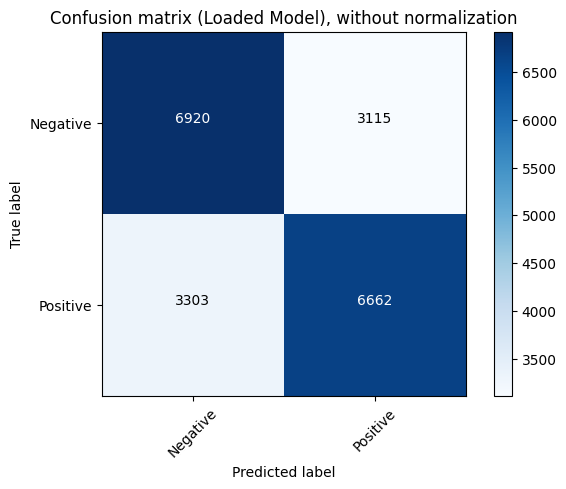

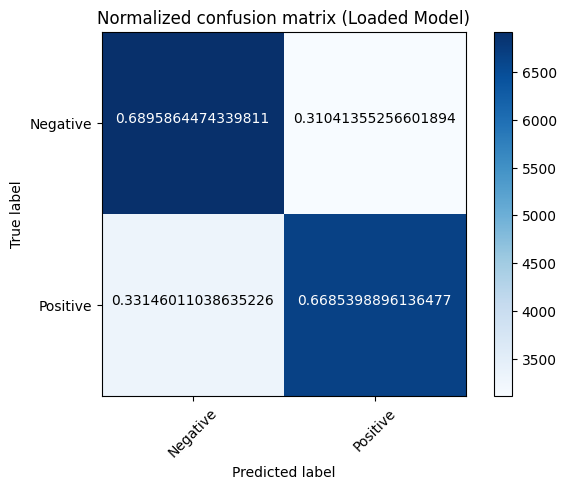

In [28]:
from joblib import load
import itertools

# Plot confusion matrix function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


loaded_model = load('decision_tree_model.h5')

# use the loaded_model to make predictions
y_pred_loaded = loaded_model.predict(X_test)

# Compute confusion matrix for the loaded model
cnf_matrix_loaded = confusion_matrix(y_test, y_pred_loaded)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'],
                      title='Confusion matrix (Loaded Model), without normalization')

# Plot normalized confusion matrix for the loaded model
plt.figure()
plot_confusion_matrix(cnf_matrix_loaded, classes=['Negative', 'Positive'], normalize=True,
                      title='Normalized confusion matrix (Loaded Model)')

plt.show()


# **Deep Learning Models**

## **1. ANN**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Convert the labels to binary format (0 or 1)
y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)

# Convert the binary feature DataFrame to a NumPy array
X_train = X_train.values
X_test = X_test.values

# Define the neural network architecture with L2 regularization
model = Sequential()
model.add(Dense(60, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(40, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))



# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=15, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)


# Calculate precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
print(classification_report(y_test, y_pred))

# Save the trained model
model.save("ann_model.h5")


Epoch 1/15
157/157 [==============================] - 10s 45ms/step - loss: 1.0257 - accuracy: 0.6291 - val_loss: 0.6971 - val_accuracy: 0.7214
Epoch 2/15
157/157 [==============================] - 5s 32ms/step - loss: 0.6679 - accuracy: 0.6980 - val_loss: 0.6302 - val_accuracy: 0.7321
Epoch 3/15
157/157 [==============================] - 3s 21ms/step - loss: 0.6399 - accuracy: 0.7086 - val_loss: 0.6207 - val_accuracy: 0.7283
Epoch 4/15
157/157 [==============================] - 3s 20ms/step - loss: 0.6330 - accuracy: 0.7108 - val_loss: 0.6126 - val_accuracy: 0.7353
Epoch 5/15
157/157 [==============================] - 3s 21ms/step - loss: 0.6286 - accuracy: 0.7128 - val_loss: 0.6101 - val_accuracy: 0.7325
Epoch 6/15
157/157 [==============================] - 3s 22ms/step - loss: 0.6245 - accuracy: 0.7153 - val_loss: 0.6042 - val_accuracy: 0.7382
Epoch 7/15
157/157 [==============================] - 2s 13ms/step - loss: 0.6230 - accuracy: 0.7156 - val_loss: 0.6049 - val_accuracy: 0.732

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **1.2 Affichage ANN**

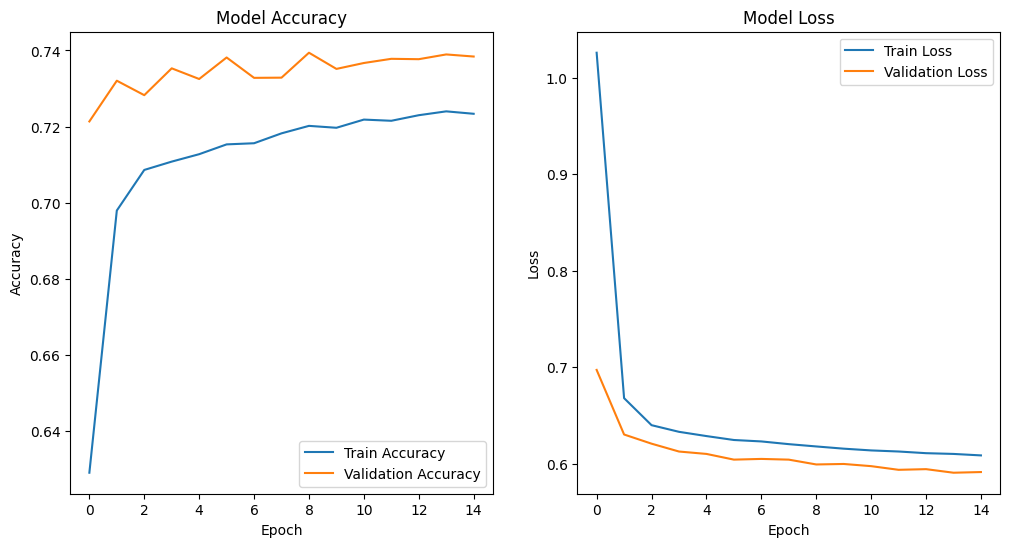

625/625 [==============================] - 2s 3ms/step


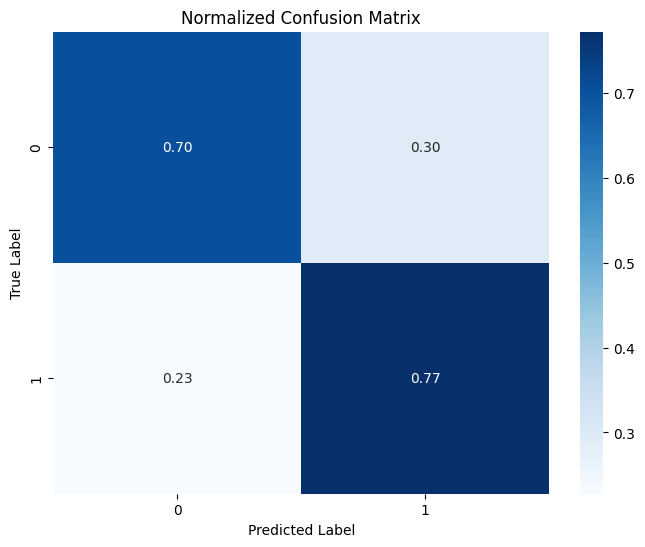

In [ ]:
# Accuracy plot
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Generate predictions
y_pred_prob = model.predict(X_test)

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **2. RNN**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Convert the labels to binary format (0 or 1)
y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)

# Convert the binary feature DataFrame to a NumPy array
X_train = X_train.values
X_test = X_test.values

# Define the neural network architecture
model = Sequential()
model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Reshape((1, 30)))
model.add(SimpleRNN(45, return_sequences=True))
model.add(SimpleRNN(35))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=15, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
print(classification_report(y_test, y_pred))

# Save the trained model
model.save("rnn_model.h5")


Epoch 1/15
157/157 [==============================] - 9s 26ms/step - loss: 0.6988 - accuracy: 0.6733 - val_loss: 0.5686 - val_accuracy: 0.7398
Epoch 2/15
157/157 [==============================] - 4s 24ms/step - loss: 0.5804 - accuracy: 0.7301 - val_loss: 0.5623 - val_accuracy: 0.7409
Epoch 3/15
157/157 [==============================] - 3s 20ms/step - loss: 0.5761 - accuracy: 0.7326 - val_loss: 0.5685 - val_accuracy: 0.7355
Epoch 4/15
157/157 [==============================] - 2s 14ms/step - loss: 0.5757 - accuracy: 0.7326 - val_loss: 0.5611 - val_accuracy: 0.7438
Epoch 5/15
157/157 [==============================] - 2s 13ms/step - loss: 0.5733 - accuracy: 0.7335 - val_loss: 0.5621 - val_accuracy: 0.7441
Epoch 6/15
157/157 [==============================] - 2s 13ms/step - loss: 0.5732 - accuracy: 0.7350 - val_loss: 0.5613 - val_accuracy: 0.7445
Epoch 7/15
157/157 [==============================] - 2s 13ms/step - loss: 0.5726 - accuracy: 0.7361 - val_loss: 0.5639 - val_accuracy: 0.7431

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **2.1. Affichage RNN**

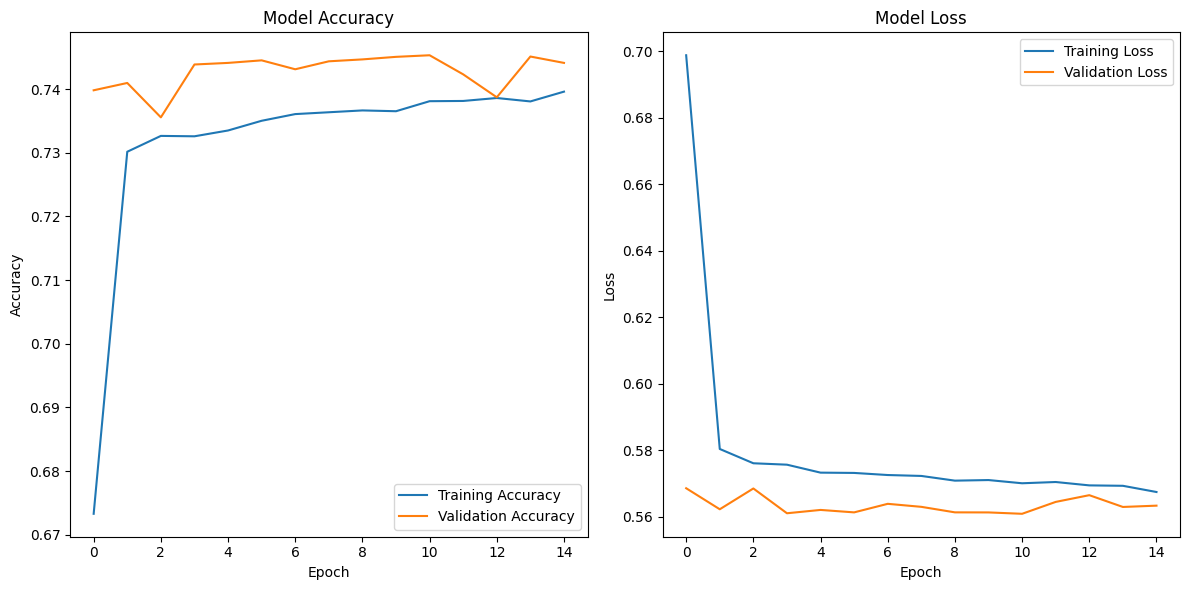

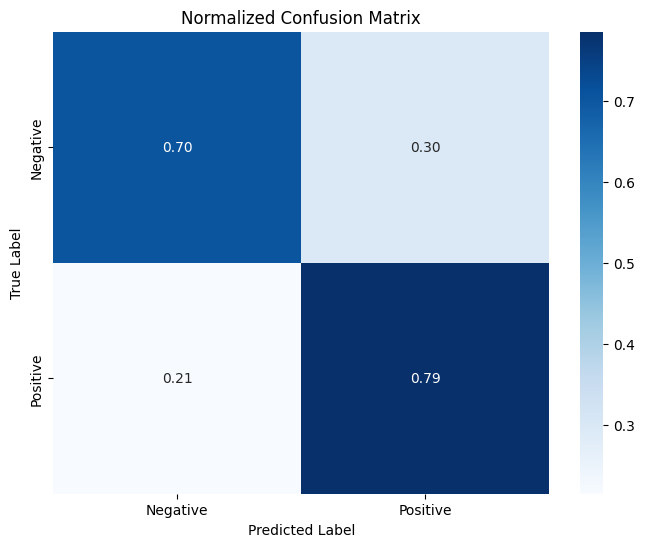

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **3. LSTM (Simple layer of LSTM)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Convert the labels to binary format (0 or 1)
y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)

# Convert the binary feature DataFrame to a NumPy array
X_train = X_train.values
X_test = X_test.values

# Define the neural network
model = Sequential()
model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(60, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Reshape((1, 60)))
model.add(LSTM(35))
model.add(Dense(1, activation='sigmoid'))


# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=15, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)


# Calculate precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
print(classification_report(y_test, y_pred))

# Save the trained model
model.save("lstm_model.h5")


Epoch 1/15
157/157 [==============================] - 12s 40ms/step - loss: 0.7559 - accuracy: 0.6089 - val_loss: 0.5932 - val_accuracy: 0.7348
Epoch 2/15
157/157 [==============================] - 5s 30ms/step - loss: 0.6075 - accuracy: 0.7189 - val_loss: 0.5746 - val_accuracy: 0.7436
Epoch 3/15
157/157 [==============================] - 5s 32ms/step - loss: 0.5926 - accuracy: 0.7262 - val_loss: 0.5733 - val_accuracy: 0.7419
Epoch 4/15
157/157 [==============================] - 4s 26ms/step - loss: 0.5883 - accuracy: 0.7297 - val_loss: 0.5681 - val_accuracy: 0.7444
Epoch 5/15
157/157 [==============================] - 2s 16ms/step - loss: 0.5846 - accuracy: 0.7298 - val_loss: 0.5675 - val_accuracy: 0.7453
Epoch 6/15
157/157 [==============================] - 2s 16ms/step - loss: 0.5835 - accuracy: 0.7304 - val_loss: 0.5669 - val_accuracy: 0.7439
Epoch 7/15
157/157 [==============================] - 2s 16ms/step - loss: 0.5819 - accuracy: 0.7317 - val_loss: 0.5616 - val_accuracy: 0.745

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **3.1. Affichage LSTM**

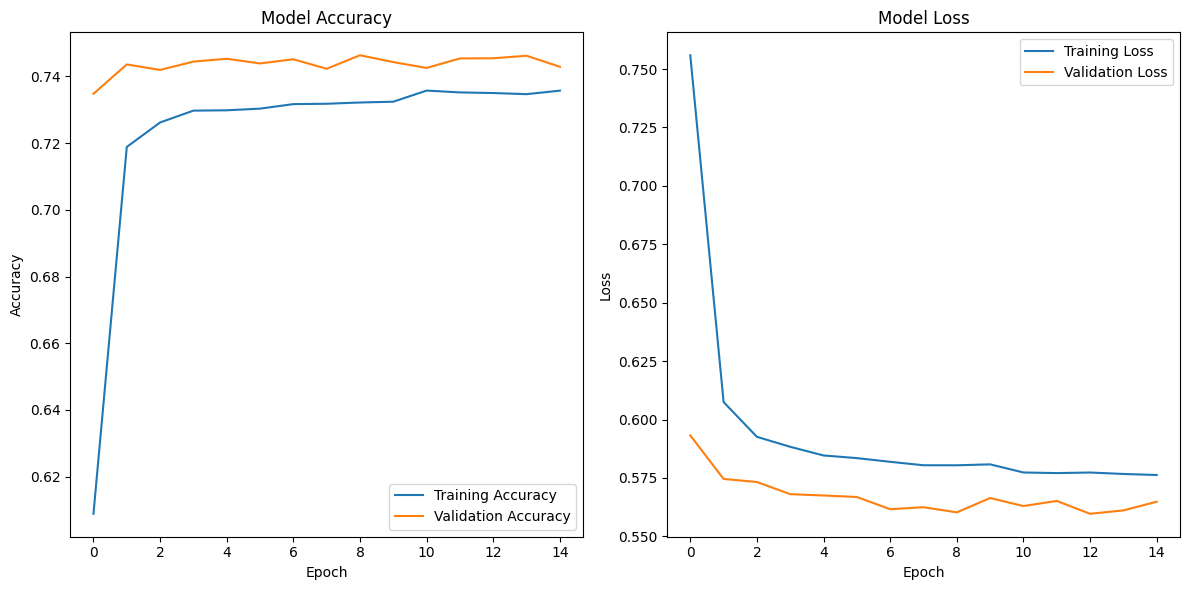

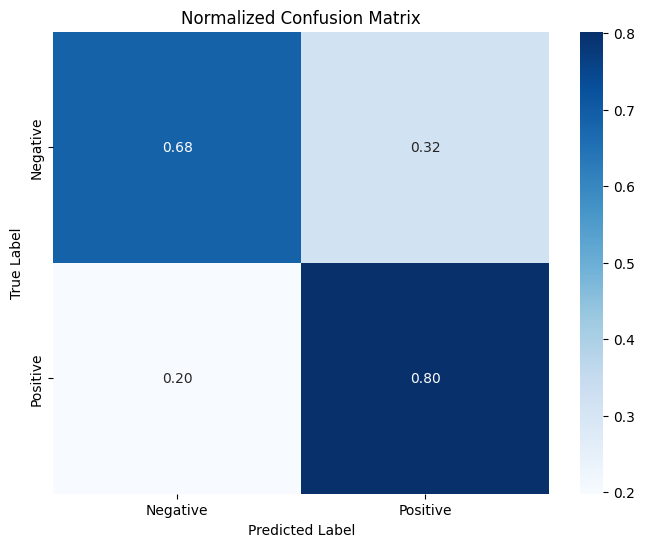

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **4. CNN (CONV1D)**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Convert the labels to binary format (0 or 1)
y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)

# Convert the binary feature DataFrame to a NumPy array
X_train = X_train.values
X_test = X_test.values

# Define the neural network architecture
model = Sequential()
model.add(Conv1D(64, 5, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=15, batch_size=512,
                    validation_data=(X_test.reshape(-1, X_test.shape[1], 1), y_test),
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test.reshape(-1, X_test.shape[1], 1), y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test.reshape(-1, X_test.shape[1], 1))

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model
model.save("cnn_model.h5")


Epoch 1/15
157/157 [==============================] - 166s 1s/step - loss: 0.6596 - accuracy: 0.6747 - val_loss: 0.6300 - val_accuracy: 0.6982
Epoch 2/15
157/157 [==============================] - 148s 941ms/step - loss: 0.6341 - accuracy: 0.6964 - val_loss: 0.6257 - val_accuracy: 0.7013
Epoch 3/15
157/157 [==============================] - 152s 972ms/step - loss: 0.6304 - accuracy: 0.7025 - val_loss: 0.6224 - val_accuracy: 0.7059
Epoch 4/15
157/157 [==============================] - 153s 973ms/step - loss: 0.6291 - accuracy: 0.7023 - val_loss: 0.6187 - val_accuracy: 0.7123
Epoch 5/15
157/157 [==============================] - 147s 930ms/step - loss: 0.6256 - accuracy: 0.7066 - val_loss: 0.6207 - val_accuracy: 0.7069
Epoch 6/15
157/157 [==============================] - 153s 974ms/step - loss: 0.6228 - accuracy: 0.7075 - val_loss: 0.6099 - val_accuracy: 0.7157
Epoch 7/15
157/157 [==============================] - 151s 962ms/step - loss: 0.6214 - accuracy: 0.7089 - val_loss: 0.6112 - va

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **4.1 Affichage CNN**

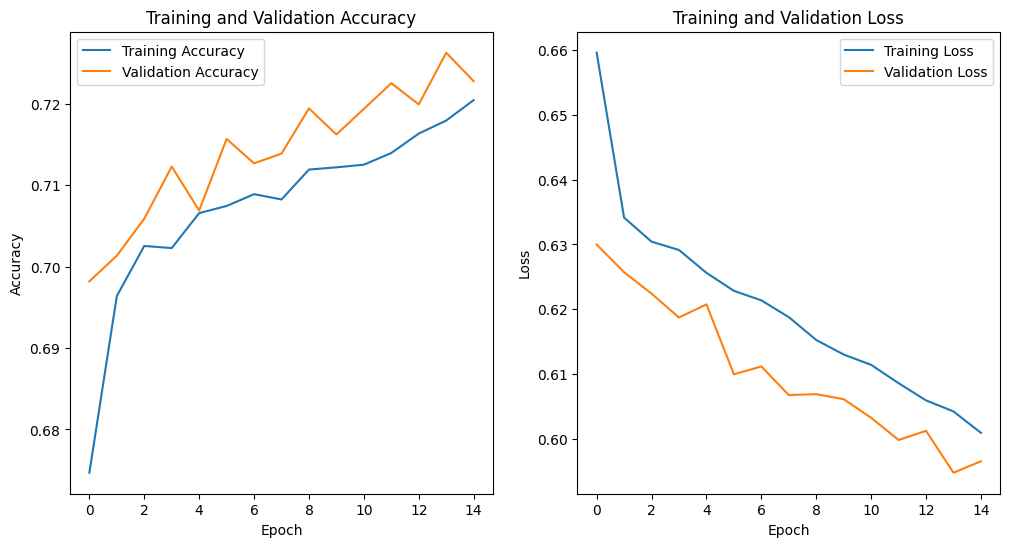

625/625 [==============================] - 10s 15ms/step


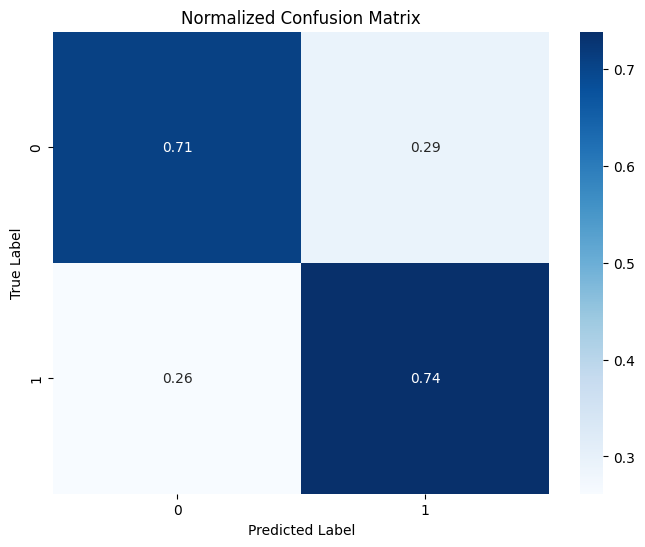

In [ ]:
# Plot training history: Accuracy and Loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Predict probabilities for test set
y_pred_prob = model.predict(X_test.reshape(-1, X_test.shape[1], 1))

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', fmt='.2f')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



# **5. Combined modal CNN+BI-LSTM**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Convert the labels to binary format (0 or 1)
y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)

# Convert the binary feature DataFrame to a NumPy array
X_train = X_train.values
X_test = X_test.values

# Define the neural network architecture
model = Sequential()
model.add(Conv1D(64, 5, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=4))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Reshape((1, 128)))  # Reshape for LSTM input
model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(X_train.reshape(-1, X_train.shape[1], 1), y_train, epochs=15, batch_size=512,
                    validation_data=(X_test.reshape(-1, X_test.shape[1], 1), y_test),
                    callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test.reshape(-1, X_test.shape[1], 1), y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test.reshape(-1, X_test.shape[1], 1))

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Save the trained model
model.save("cnn_bilstm_model.h5")


Epoch 1/15
157/157 [==============================] - 223s 1s/step - loss: 0.6648 - accuracy: 0.6616 - val_loss: 0.6356 - val_accuracy: 0.7006
Epoch 2/15
157/157 [==============================] - 231s 1s/step - loss: 0.6370 - accuracy: 0.6996 - val_loss: 0.6211 - val_accuracy: 0.7121
Epoch 3/15
157/157 [==============================] - 165s 1s/step - loss: 0.6255 - accuracy: 0.7066 - val_loss: 0.6125 - val_accuracy: 0.7175
Epoch 4/15
157/157 [==============================] - 162s 1s/step - loss: 0.6155 - accuracy: 0.7118 - val_loss: 0.6085 - val_accuracy: 0.7182
Epoch 5/15
157/157 [==============================] - 161s 1s/step - loss: 0.6106 - accuracy: 0.7142 - val_loss: 0.5965 - val_accuracy: 0.7254
Epoch 6/15
157/157 [==============================] - 163s 1s/step - loss: 0.6045 - accuracy: 0.7183 - val_loss: 0.5955 - val_accuracy: 0.7245
Epoch 7/15
157/157 [==============================] - 164s 1s/step - loss: 0.6000 - accuracy: 0.7221 - val_loss: 0.5933 - val_accuracy: 0.7243

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **5.1. Affichage CNN+BI-LSTM**

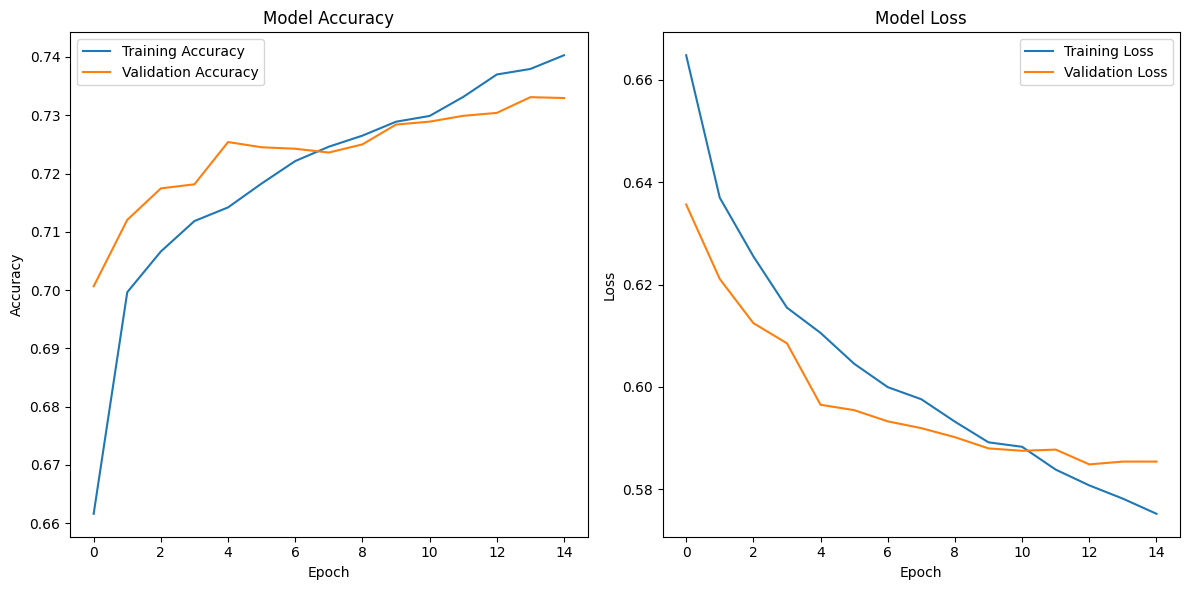

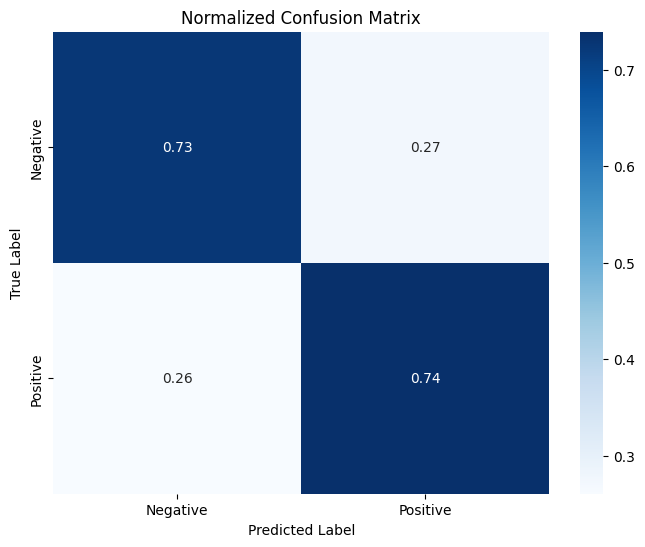

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **6. BI-LSTM**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Convert the labels to binary format (0 or 1)
y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)

# Convert the binary feature DataFrame to a NumPy array
X_train = X_train.values
X_test = X_test.values

# Define the neural network architecture
model = Sequential()
model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Reshape((1, 30)))
model.add(Bidirectional(LSTM(45, return_sequences=True)))
model.add(Bidirectional(LSTM(35)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=15, batch_size=512, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
print(classification_report(y_test, y_pred))

# Save the trained model
model.save("bidirectional_lstm_model.h5")


Epoch 1/15
157/157 [==============================] - 20s 40ms/step - loss: 0.7165 - accuracy: 0.6405 - val_loss: 0.5709 - val_accuracy: 0.7368
Epoch 2/15
157/157 [==============================] - 6s 38ms/step - loss: 0.5832 - accuracy: 0.7290 - val_loss: 0.5678 - val_accuracy: 0.7406
Epoch 3/15
157/157 [==============================] - 4s 27ms/step - loss: 0.5784 - accuracy: 0.7306 - val_loss: 0.5657 - val_accuracy: 0.7404
Epoch 4/15
157/157 [==============================] - 5s 29ms/step - loss: 0.5762 - accuracy: 0.7333 - val_loss: 0.5625 - val_accuracy: 0.7416
Epoch 5/15
157/157 [==============================] - 6s 39ms/step - loss: 0.5747 - accuracy: 0.7347 - val_loss: 0.5636 - val_accuracy: 0.7415
Epoch 6/15
157/157 [==============================] - 4s 26ms/step - loss: 0.5747 - accuracy: 0.7361 - val_loss: 0.5646 - val_accuracy: 0.7415
Epoch 7/15
157/157 [==============================] - 5s 35ms/step - loss: 0.5735 - accuracy: 0.7353 - val_loss: 0.5623 - val_accuracy: 0.743

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **6.1 Affichage BI-LSTM**

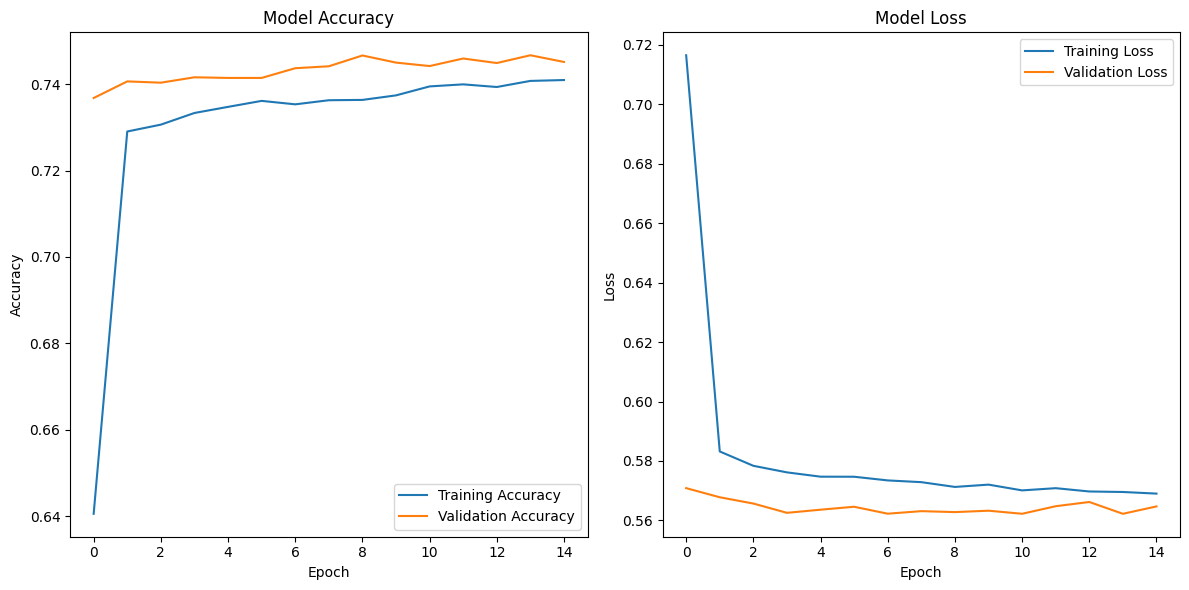

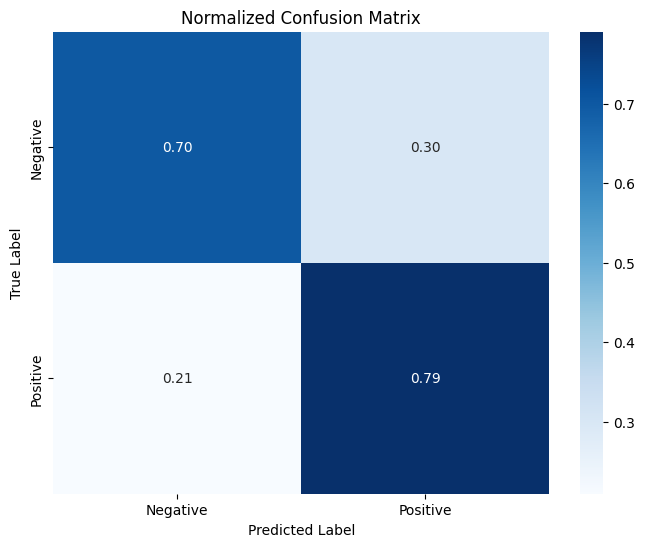

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **7. GRU Bidirectional**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, GRU, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Convert the labels to binary format (0 or 1)
y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)

# Convert the binary feature DataFrame to a NumPy array
X_train = X_train.values
X_test = X_test.values

# Define the neural network architecture with L2 regularization and multiple Bidirectional GRU layers
model = Sequential()
model.add(Dense(30, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Reshape((1, 30)))
model.add(Bidirectional(GRU(45, return_sequences=True)))
model.add(Bidirectional(GRU(35)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=15, batch_size=250, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

# Predict probabilities for test set
y_pred_prob = model.predict(X_test)

# Threshold probabilities to get predicted classes
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision, recall, f1-score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Classification Report
print(classification_report(y_test, y_pred))

# Save the trained model
model.save("bidirectional_gru_model.h5")

Epoch 1/15
320/320 [==============================] - 27s 41ms/step - loss: 0.6536 - accuracy: 0.6871 - val_loss: 0.5801 - val_accuracy: 0.7345
Epoch 2/15
320/320 [==============================] - 5s 16ms/step - loss: 0.5941 - accuracy: 0.7263 - val_loss: 0.5808 - val_accuracy: 0.7365
Epoch 3/15
320/320 [==============================] - 5s 15ms/step - loss: 0.5917 - accuracy: 0.7301 - val_loss: 0.5766 - val_accuracy: 0.7387
Epoch 4/15
320/320 [==============================] - 7s 21ms/step - loss: 0.5891 - accuracy: 0.7312 - val_loss: 0.5751 - val_accuracy: 0.7404
Epoch 5/15
320/320 [==============================] - 5s 15ms/step - loss: 0.5887 - accuracy: 0.7307 - val_loss: 0.5758 - val_accuracy: 0.7393
Epoch 6/15
320/320 [==============================] - 6s 18ms/step - loss: 0.5900 - accuracy: 0.7292 - val_loss: 0.5787 - val_accuracy: 0.7426
Epoch 7/15
320/320 [==============================] - 6s 18ms/step - loss: 0.5890 - accuracy: 0.7305 - val_loss: 0.5742 - val_accuracy: 0.743

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# **7.1 Affichage GRU Bidirectional**

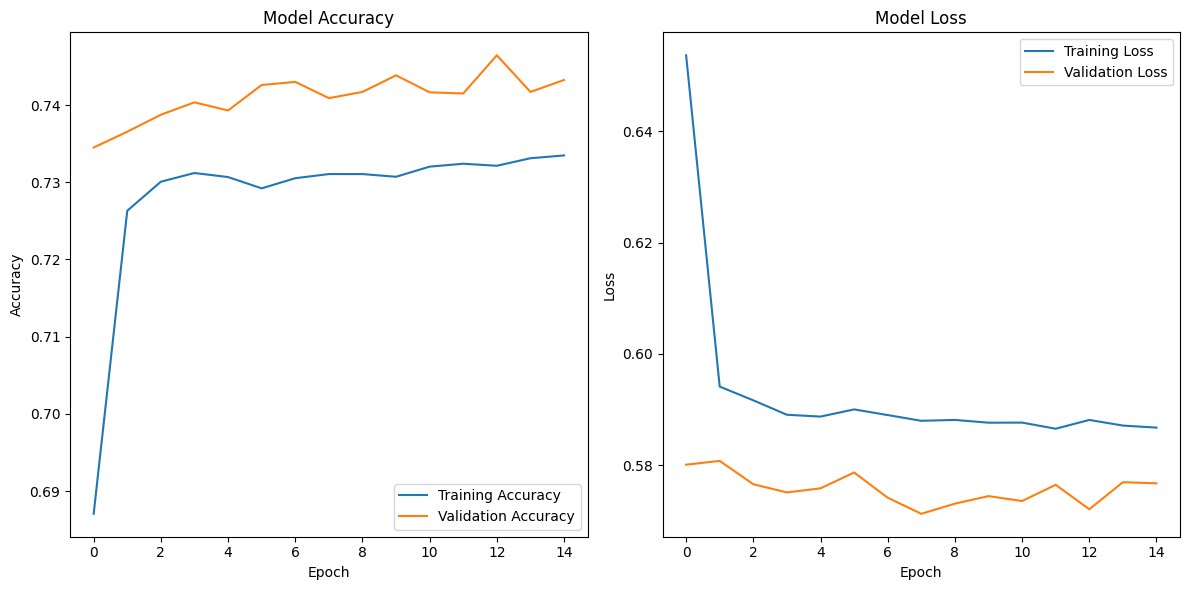

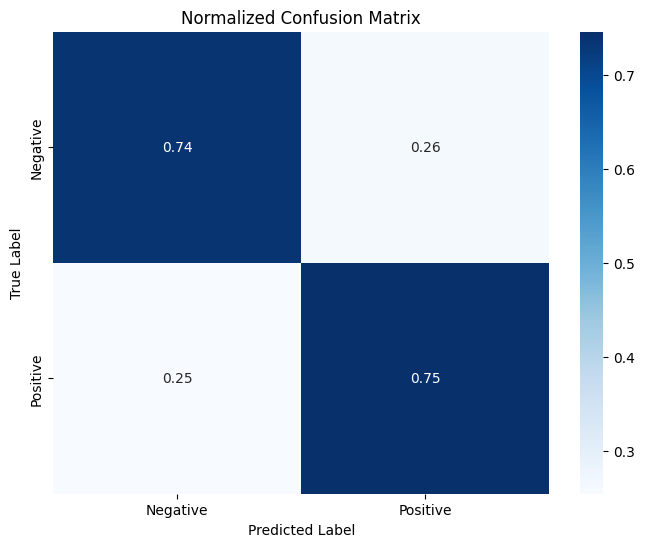

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay


# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize confusion matrix

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


# **ROC Comparaison Machine Learning**

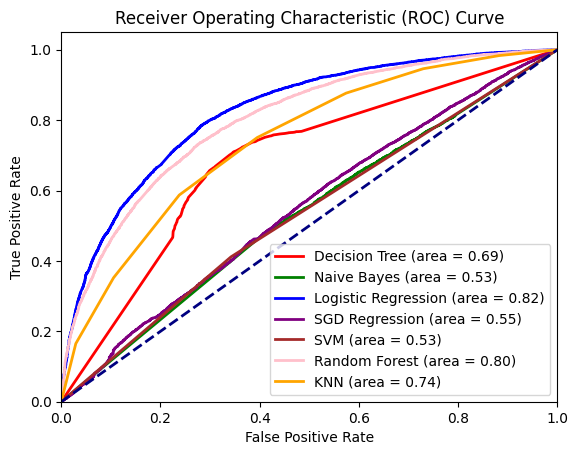

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import joblib

# Read the sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)
y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)
X_train = X_train.values
X_test = X_test.values

# Load the Decision Tree model
decision_tree_model = joblib.load('decision_tree_model.h5')
y_pred_decision_tree = decision_tree_model.predict_proba(X_test)[:, 1]

# Load the Naive Bayes model
naive_bayes_model = joblib.load('naive_bayes_model.h5')
y_pred_naive_bayes = naive_bayes_model.predict_proba(X_test)[:, 1]

# Load the Logistic Regression model
logistic_regression_model = joblib.load('logistic_regression_model.h5')
y_pred_logistic_regression = logistic_regression_model.predict_proba(X_test)[:, 1]

# Load the SGD Regression model
sgd_regression_model = joblib.load('sgd_regression_model.h5')
y_pred_sgd_regression = sgd_regression_model.predict(X_test)

# Load the SVM model
svm_model = joblib.load('svm_model.h5')
y_pred_svm = svm_model.predict(X_test)

# Load the Random Forest Classifier model
random_forest_classifier_model = joblib.load('random_forest_classifier_model.h5')
y_pred_random_forest = random_forest_classifier_model.predict_proba(X_test)[:, 1]

# Load the KNN model
knn_model = joblib.load('knn_model.h5')
y_pred_knn = knn_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each model
fpr_decision_tree, tpr_decision_tree, _ = roc_curve(y_test, y_pred_decision_tree)
roc_auc_decision_tree = auc(fpr_decision_tree, tpr_decision_tree)

fpr_naive_bayes, tpr_naive_bayes, _ = roc_curve(y_test, y_pred_naive_bayes)
roc_auc_naive_bayes = auc(fpr_naive_bayes, tpr_naive_bayes)

fpr_logistic_regression, tpr_logistic_regression, _ = roc_curve(y_test, y_pred_logistic_regression)
roc_auc_logistic_regression = auc(fpr_logistic_regression, tpr_logistic_regression)

fpr_sgd_regression, tpr_sgd_regression, _ = roc_curve(y_test, y_pred_sgd_regression)
roc_auc_sgd_regression = auc(fpr_sgd_regression, tpr_sgd_regression)

fpr_svm, tpr_svm, _ = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_random_forest, tpr_random_forest, _ = roc_curve(y_test, y_pred_random_forest)
roc_auc_random_forest = auc(fpr_random_forest, tpr_random_forest)

fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot ROC curves
plt.figure()
lw = 2
plt.plot(fpr_decision_tree, tpr_decision_tree, color='red',
         lw=lw, label='Decision Tree (area = %0.2f)' % roc_auc_decision_tree)
plt.plot(fpr_naive_bayes, tpr_naive_bayes, color='green',
         lw=lw, label='Naive Bayes (area = %0.2f)' % roc_auc_naive_bayes)
plt.plot(fpr_logistic_regression, tpr_logistic_regression, color='blue',
         lw=lw, label='Logistic Regression (area = %0.2f)' % roc_auc_logistic_regression)
plt.plot(fpr_sgd_regression, tpr_sgd_regression, color='purple',
         lw=lw, label='SGD Regression (area = %0.2f)' % roc_auc_sgd_regression)
plt.plot(fpr_svm, tpr_svm, color='brown',
         lw=lw, label='SVM (area = %0.2f)' % roc_auc_svm)
plt.plot(fpr_random_forest, tpr_random_forest, color='pink',
         lw=lw, label='Random Forest (area = %0.2f)' % roc_auc_random_forest)
plt.plot(fpr_knn, tpr_knn, color='orange',
         lw=lw, label='KNN (area = %0.2f)' % roc_auc_knn)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# **ROC Comparison Deep Learning**

625/625 [==============================] - 2s 2ms/step


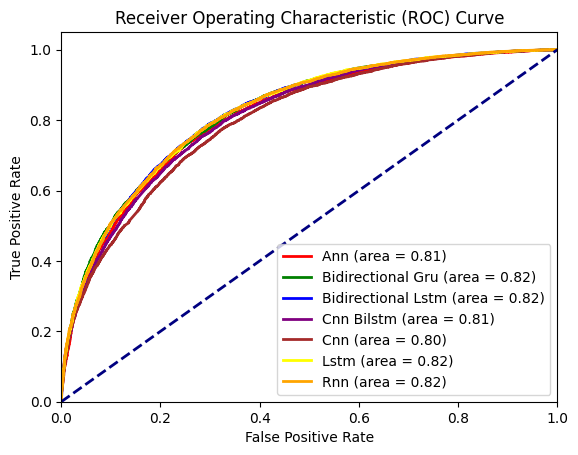

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Read sentiment labels (0 or 4) from the first column of the dataset
sentiments = df[df.columns[0]].values

# Split the binary feature DataFrame into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(binary_feature_df, sentiments, test_size=0.2, random_state=42)

# Convert labels to binary format (0 or 1)
y_train = (y_train == 4).astype(int)
y_test = (y_test == 4).astype(int)

# Convert the binary feature DataFrame to a NumPy array
X_train, X_test = X_train.values, X_test.values

# Load models
models = {
    'Ann': load_model('ann_model.h5'),
    'Bidirectional Gru': load_model('bidirectional_gru_model.h5'),
    'Bidirectional Lstm': load_model('bidirectional_lstm_model.h5'),
    'Cnn Bilstm': load_model('cnn_bilstm_model.h5'),
    'Cnn': load_model('cnn_model.h5'),
    'Lstm': load_model('lstm_model.h5'),
    'Rnn': load_model('rnn_model.h5')
}

# Plot ROC curves
plt.figure()
lw = 2
colors = ['red', 'green', 'blue', 'purple', 'brown', 'yellow', 'orange']

for i, (model_name, model) in enumerate(models.items()):
    y_pred = model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i], lw=lw,
             label=f'{model_name.replace("_", " ").title()} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# **Models testing Using ML**

In [12]:
import numpy as np
import joblib

def ML_predict_tweet_sentiment(tweet):
    # Preprocess the tweet
    preprocessed_tweet = preprocess_tweet(tweet)

    # Convert the preprocessed tweet to a binary feature vector
    binary_feature_vector = binary_feature_extraction([preprocessed_tweet], vocab_word_to_index)

    # Define a dictionary of model names and their corresponding loaded models
    models = {
        'Decision Tree': joblib.load('decision_tree_model.h5'),
        'Logistic Regression': joblib.load('logistic_regression_model.h5'),
        'Naive Bayes': joblib.load('naive_bayes_model.h5'),
        'SGD Regression': joblib.load('sgd_regression_model.h5'),
        'SVM': joblib.load('svm_model.h5'),
        'Random Forest Classifier': joblib.load('random_forest_classifier_model.h5'),
        'KNN': joblib.load('knn_model.h5')
    }

    # Iterate over the models dictionary to make predictions for each model
    for model_name, model in models.items():
        # Predict the sentiment of the tweet using the current model
        if model_name in ['SVM', 'SGD Regression', 'KNN']:
            prediction = model.predict(binary_feature_vector)
        else:
            prediction = model.predict_proba(binary_feature_vector)[:, 1]

        # Print the prediction
        if prediction[0] >= 0.5:
            print(f"The tweet is classified as positive by {model_name}.")
        else:
            print(f"The tweet is classified as negative by {model_name}.")


**Positive Tweet**

In [15]:
# Example usage:
tweet_to_predict = "I had the most wonderful day today! The weather was perfect, and I spent the afternoon with my friends, laughing and enjoying each other's company. Later, we went for a delicious dinner at our favorite restaurant, and the food was absolutely amazing. I feel so grateful for moments like these, filled with joy and happiness. It's days like this that remind me how beautiful life can be. #blessed #grateful"
ML_predict_tweet_sentiment(tweet_to_predict)

The tweet is classified as negative by Decision Tree.
The tweet is classified as positive by Logistic Regression.
The tweet is classified as negative by Naive Bayes.
The tweet is classified as positive by SGD Regression.
The tweet is classified as negative by SVM.
The tweet is classified as positive by Random Forest Classifier.
The tweet is classified as positive by KNN.


**Negative tweet**

In [17]:
# Example usage:
tweet_to_predict = "Feeling a bit under the weather today. Nothing seems to be going right. #MondayBlues"
ML_predict_tweet_sentiment(tweet_to_predict)

The tweet is classified as negative by Decision Tree.
The tweet is classified as negative by Logistic Regression.
The tweet is classified as positive by Naive Bayes.
The tweet is classified as positive by SGD Regression.
The tweet is classified as negative by SVM.
The tweet is classified as negative by Random Forest Classifier.
The tweet is classified as negative by KNN.


**Same tweet as before but with added noise**

In [18]:
# Example usage:
tweet_to_predict = "Feeling a bit https://hrllo.com @trytest 7_*$a5 0g  ofnbiv under the weather today. Nothing seems to be going right. #MondayBlues"
ML_predict_tweet_sentiment(tweet_to_predict)

The tweet is classified as negative by Decision Tree.
The tweet is classified as negative by Logistic Regression.
The tweet is classified as positive by Naive Bayes.
The tweet is classified as positive by SGD Regression.
The tweet is classified as negative by SVM.
The tweet is classified as negative by Random Forest Classifier.
The tweet is classified as negative by KNN.


**Positive tweet**

In [19]:
# Example usage:
tweet_to_predict = "working hard give the best result. Keep it up !"
ML_predict_tweet_sentiment(tweet_to_predict)

The tweet is classified as positive by Decision Tree.
The tweet is classified as positive by Logistic Regression.
The tweet is classified as negative by Naive Bayes.
The tweet is classified as positive by SGD Regression.
The tweet is classified as negative by SVM.
The tweet is classified as positive by Random Forest Classifier.
The tweet is classified as negative by KNN.


**Simple Positive tweet**

In [20]:
# Example usage:
tweet_to_predict = "I like apple"
ML_predict_tweet_sentiment(tweet_to_predict)

The tweet is classified as positive by Decision Tree.
The tweet is classified as positive by Logistic Regression.
The tweet is classified as positive by Naive Bayes.
The tweet is classified as positive by SGD Regression.
The tweet is classified as positive by SVM.
The tweet is classified as positive by Random Forest Classifier.
The tweet is classified as positive by KNN.


**Simple Negative Tweet**

In [21]:
# Example usage:
tweet_to_predict = "I hate apple"
ML_predict_tweet_sentiment(tweet_to_predict)

The tweet is classified as negative by Decision Tree.
The tweet is classified as negative by Logistic Regression.
The tweet is classified as positive by Naive Bayes.
The tweet is classified as positive by SGD Regression.
The tweet is classified as positive by SVM.
The tweet is classified as negative by Random Forest Classifier.
The tweet is classified as negative by KNN.


# **Models testing Using DL**

In [22]:
import numpy as np
from tensorflow.keras.models import load_model

def predict_tweet_sentiment(tweet):
    # Preprocess the tweet
    preprocessed_tweet = preprocess_tweet(tweet)

    # Convert the preprocessed tweet to a binary feature vector
    binary_feature_vector = binary_feature_extraction([preprocessed_tweet], vocab_word_to_index)

    # Define a dictionary of model names and their corresponding loaded models
    models = {
        'Ann': load_model('ann_model.h5'),
        'Bidirectional Gru': load_model('bidirectional_gru_model.h5'),
        'Bidirectional Lstm': load_model('bidirectional_lstm_model.h5'),
        'Cnn Bilstm': load_model('cnn_bilstm_model.h5'),
        'Cnn': load_model('cnn_model.h5'),
        'Lstm': load_model('lstm_model.h5'),
        'Rnn': load_model('rnn_model.h5')
    }

    # Iterate over the models dictionary to make predictions for each model
    for model_name, model in models.items():
        # Predict the sentiment of the tweet using the current model
        prediction = model.predict(binary_feature_vector)

        # Print the prediction
        if prediction[0] >= 0.5:
            print(f"The tweet is classified as positive by {model_name}.")
        else:
            print(f"The tweet is classified as negative by {model_name}.")



**Positive Tweet**

In [49]:
# Example usage:
tweet_to_predict = "I had the most wonderful day today! The weather was perfect, and I spent the afternoon with my friends, laughing and enjoying each other's company. Later, we went for a delicious dinner at our favorite restaurant, and the food was absolutely amazing. I feel so grateful for moments like these, filled with joy and happiness. It's days like this that remind me how beautiful life can be. #blessed #grateful"
predict_tweet_sentiment(tweet_to_predict)

1/1 [==============================] - 0s 107ms/step
The tweet is classified as positive by Ann.
1/1 [==============================] - 2s 2s/step
The tweet is classified as positive by Bidirectional Gru.
1/1 [==============================] - 2s 2s/step
The tweet is classified as positive by Bidirectional Lstm.
1/1 [==============================] - 2s 2s/step
The tweet is classified as positive by Cnn Bilstm.
1/1 [==============================] - 0s 80ms/step
The tweet is classified as positive by Cnn.
1/1 [==============================] - 0s 480ms/step
The tweet is classified as positive by Lstm.
1/1 [==============================] - 0s 303ms/step
The tweet is classified as positive by Rnn.


**Negative Tweet**

In [51]:
# Example usage:
tweet_to_predict = "Feeling a bit under the weather today. Nothing seems to be going right. #MondayBlues"
predict_tweet_sentiment(tweet_to_predict)

1/1 [==============================] - 0s 66ms/step
The tweet is classified as negative by Ann.
1/1 [==============================] - 2s 2s/step
The tweet is classified as negative by Bidirectional Gru.
1/1 [==============================] - 2s 2s/step
The tweet is classified as negative by Bidirectional Lstm.
1/1 [==============================] - 2s 2s/step
The tweet is classified as negative by Cnn Bilstm.
1/1 [==============================] - 0s 80ms/step
The tweet is classified as negative by Cnn.
1/1 [==============================] - 0s 478ms/step
The tweet is classified as negative by Lstm.
1/1 [==============================] - 0s 282ms/step
The tweet is classified as negative by Rnn.


**Same tweet as before but with added noise**

In [50]:
# Example usage:
tweet_to_predict = "Feeling a bit https://hrllo.com @trytest 7_*$a5 0g  ofnbiv under the weather today. Nothing seems to be going right. #MondayBlues"
predict_tweet_sentiment(tweet_to_predict)

1/1 [==============================] - 0s 75ms/step
The tweet is classified as negative by Ann.
1/1 [==============================] - 1s 1s/step
The tweet is classified as negative by Bidirectional Gru.
1/1 [==============================] - 3s 3s/step
The tweet is classified as negative by Bidirectional Lstm.
1/1 [==============================] - 2s 2s/step
The tweet is classified as negative by Cnn Bilstm.
1/1 [==============================] - 0s 128ms/step
The tweet is classified as negative by Cnn.
1/1 [==============================] - 1s 721ms/step
The tweet is classified as negative by Lstm.
1/1 [==============================] - 0s 444ms/step
The tweet is classified as negative by Rnn.


**Positive Tweet**

In [52]:
# Example usage:
tweet_to_predict = "working hard give the best result. Keep it up !"
predict_tweet_sentiment(tweet_to_predict)

1/1 [==============================] - 0s 74ms/step
The tweet is classified as positive by Ann.
1/1 [==============================] - 2s 2s/step
The tweet is classified as negative by Bidirectional Gru.
1/1 [==============================] - 2s 2s/step
The tweet is classified as negative by Bidirectional Lstm.
1/1 [==============================] - 2s 2s/step
The tweet is classified as positive by Cnn Bilstm.
1/1 [==============================] - 0s 121ms/step
The tweet is classified as negative by Cnn.
1/1 [==============================] - 1s 733ms/step
The tweet is classified as positive by Lstm.
1/1 [==============================] - 0s 393ms/step
The tweet is classified as positive by Rnn.


**Simple Positive Tweet**

In [26]:
# Example usage:
tweet_to_predict = "I like apple"
predict_tweet_sentiment(tweet_to_predict)

1/1 [==============================] - 0s 88ms/step
The tweet is classified as positive by Ann.
1/1 [==============================] - 3s 3s/step
The tweet is classified as positive by Bidirectional Gru.
1/1 [==============================] - 2s 2s/step
The tweet is classified as positive by Bidirectional Lstm.
1/1 [==============================] - 2s 2s/step
The tweet is classified as positive by Cnn Bilstm.
1/1 [==============================] - 0s 171ms/step
The tweet is classified as positive by Cnn.
1/1 [==============================] - 1s 820ms/step
The tweet is classified as positive by Lstm.
1/1 [==============================] - 1s 560ms/step
The tweet is classified as positive by Rnn.


**Simple Negative Tweet**

In [24]:
# Example usage:
tweet_to_predict = "I hate apple"
predict_tweet_sentiment(tweet_to_predict)

1/1 [==============================] - 0s 105ms/step
The tweet is classified as negative by Ann.
1/1 [==============================] - 2s 2s/step
The tweet is classified as negative by Bidirectional Gru.
1/1 [==============================] - 2s 2s/step
The tweet is classified as negative by Bidirectional Lstm.
1/1 [==============================] - 2s 2s/step
The tweet is classified as negative by Cnn Bilstm.
1/1 [==============================] - 0s 124ms/step
The tweet is classified as negative by Cnn.
1/1 [==============================] - 1s 753ms/step
The tweet is classified as negative by Lstm.
1/1 [==============================] - 0s 413ms/step
The tweet is classified as negative by Rnn.
